### LoopFlopy Example - Main Script

In [75]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
modelling_routines_old
observations
project
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [76]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 3. Spatial

In [77]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(349088.0373017123, 392718.4692868978, 6507368.199997337, 6546515.9098643325)

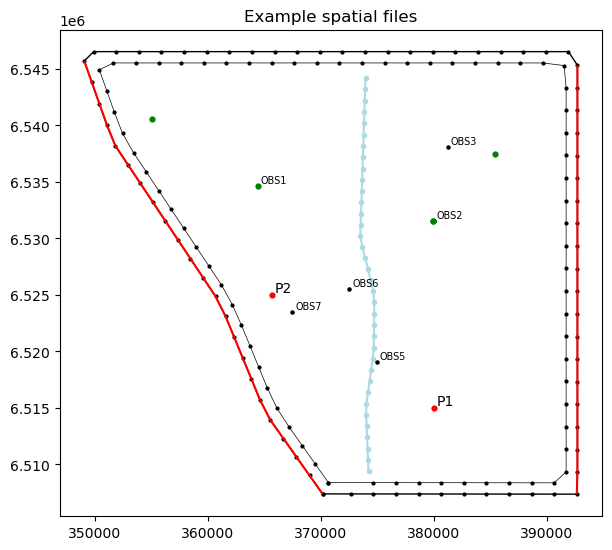

In [78]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)
process_spatial.plot_spatial(spatial)

In [79]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'ID')
spatial.model_boundary_gdf.explore(m=m, fill = False)
spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'ID')

### 3. Structural Model

In [80]:
# Create Structural Model
geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'
bbox = [(348000, 6500000, -1000), (400000, 6550000, 300)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial)
process_structural.create_structuralmodel(structuralmodel)

                          projected onto fault surface estimating from fault normal


1.6.1
Fault included!


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


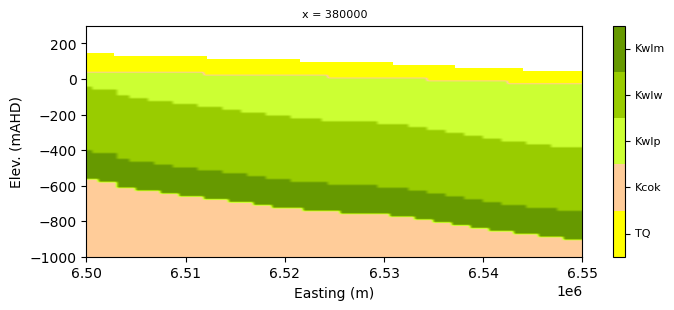

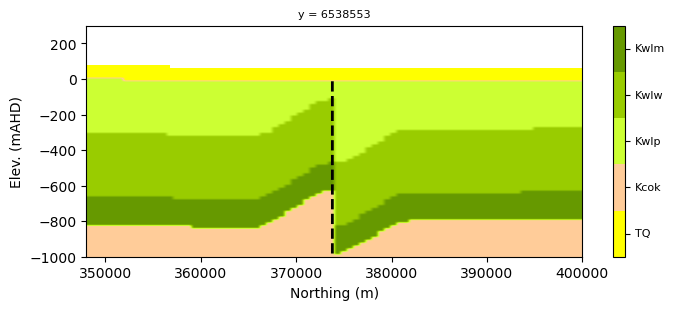

In [81]:
# Plot transects
structuralmodel.faults = ['Fault']
transect_x = [380000]
transect_y = [6538553] 
structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 80)#, x1 = 6520000, z0 = -2000) 
structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 80)#, z0 = -1200, z1 = 200) 

#structuralmodel.strat 
#structuralmodel.strat_col 
#structuralmodel.strat_names 
#structuralmodel.cmap
#structuralmodel.norm 
#structuralmodel.data

### 4. Meshing

In [84]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [85]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 3000000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['fault_nodes', 'bore_refinement_nodes',]
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

fault_nodes
bore_refinement_nodes
number of cells in plan =  1337


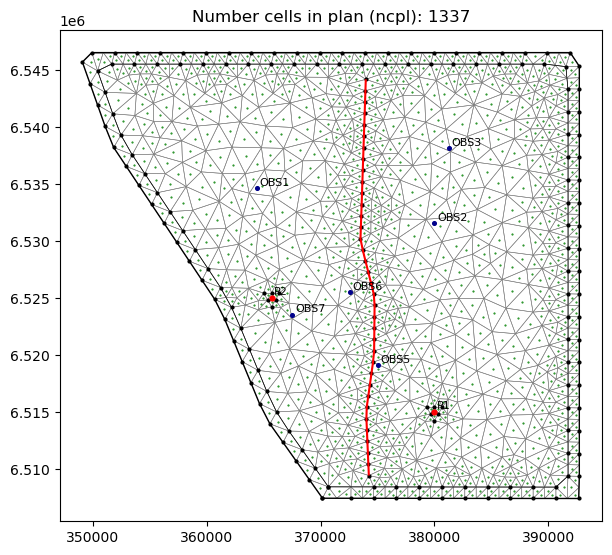

In [86]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs', 'fault']#,'river']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
Group =  wel ['pumpbores']
Group =  obs ['obsbores']


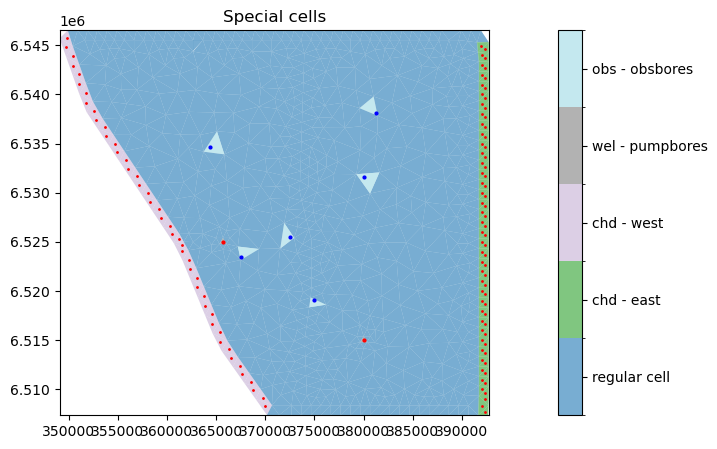

In [87]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Geomodel

In [88]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 2, res = 1)

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   Creating Geomodel (lithology and discretisation arrays) for  example  ...
Time taken =  402.064878


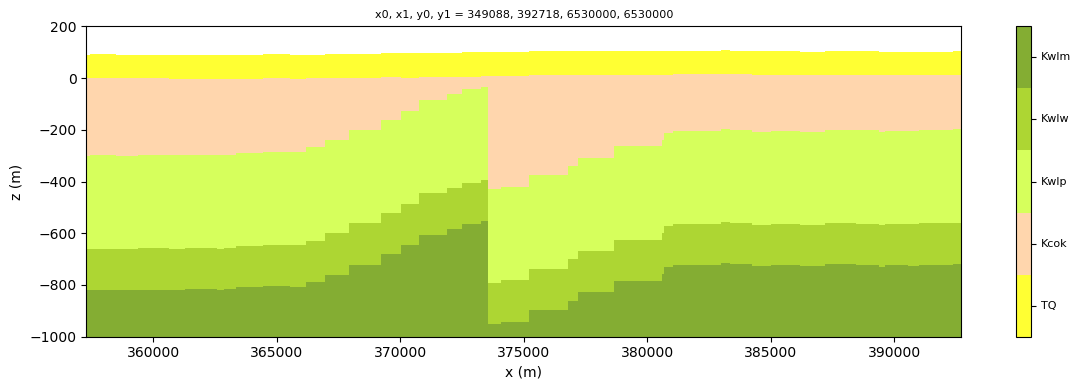

In [90]:
y0, y1 = 6530000, 6530000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1)# z0 = -200, z1 = 300

In [ ]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   Filling cell properties for  example  ...
ang1 shape  (10, 1337)
13358
angle1 shape  (13358,)
Time taken =  0.007002


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,100.0,10.00,0.0001,0.1,1.0
1,2,Kcok,0.9,0.09,0.0001,0.1,0.0
2,3,Kwlp,10.0,1.00,0.0001,0.1,0.0
3,4,Kwlw,0.9,0.09,0.0001,0.1,0.0
4,5,Kwlm,10.0,1.00,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [94]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [-100000, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)


Well screens  [(np.float64(-1000.0), np.float64(32.0)), (np.float64(-1000.0), np.float64(6.0))]


In [95]:
from loopflopy.observations import Observations
observations = Observations(spatial.obsbore_gdf )
observations.process_obs(spatial, geomodel, mesh)

### 8. Create and run steady-state flow model

In [96]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
   Time taken to write flow model =  4.617632
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  4.042728
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


In [97]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
chd
chdflow
data
geomodel
gwf
head
lith
logk11
logk33
mesh
newtonoptions
obs
obsdata
observations
project
rch
runtime
scenario
spd
staggered
wel
xt3d


Node one based =  1508 Node zero based =  1507
XYZ problem =  367080.4271155423 6545849.123178679 9.25
cell width approx  999.9999999755528
cell length approx  1000.0051903277636
cell thickness 42.5
lay, icpl (1, 170)


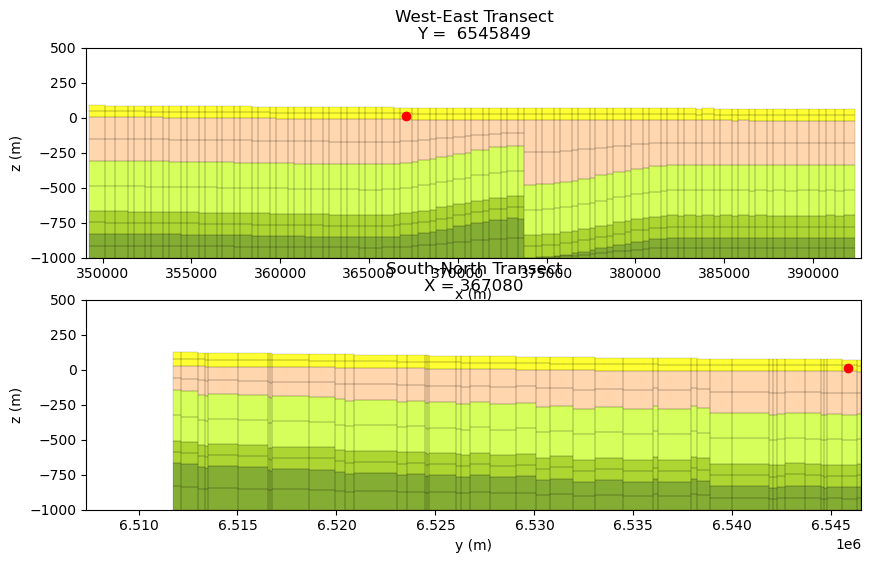

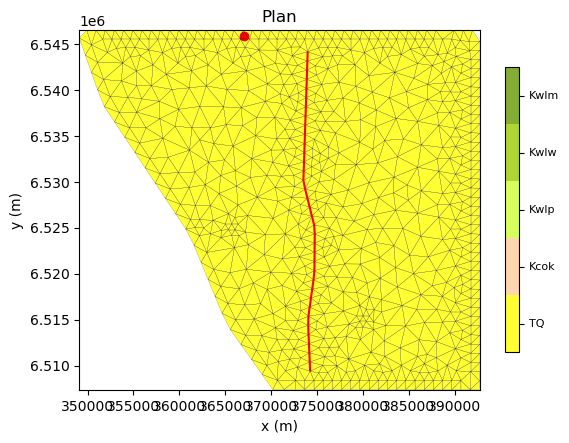

In [99]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, features = ['fault'])

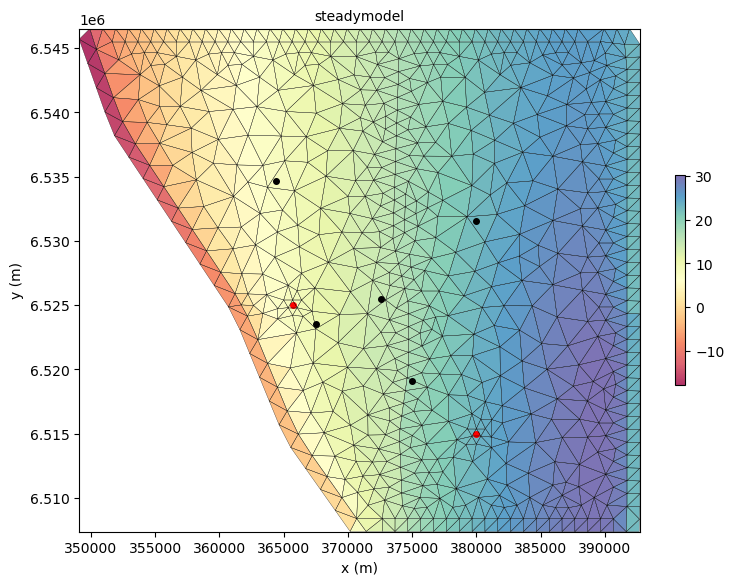

In [100]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

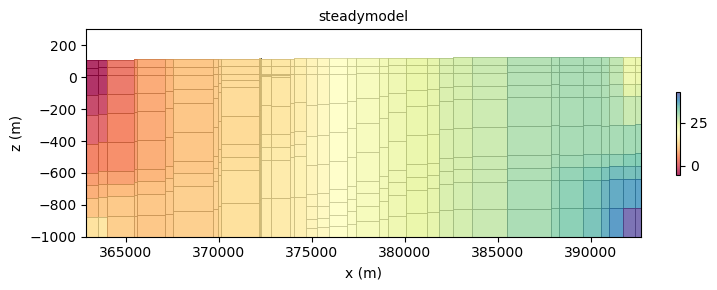

In [101]:
fm.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

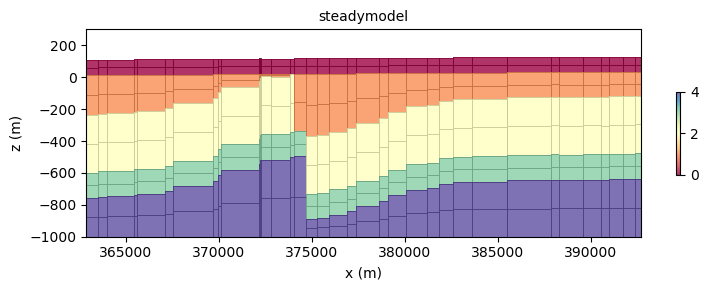

In [102]:
fm.plot_transect(spatial, structuralmodel, 'lith', y0 = 6520000, y1 = 6520000)

In [103]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### 9. Create and run transient flow model

In [62]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(32.0)), (np.float64(-1000.0), np.float64(6.0))]


In [63]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

   Writing simulation and gwf for  transientmodel  ...
   Time taken to write flow model =  5.524102


In [64]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  10.117995
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


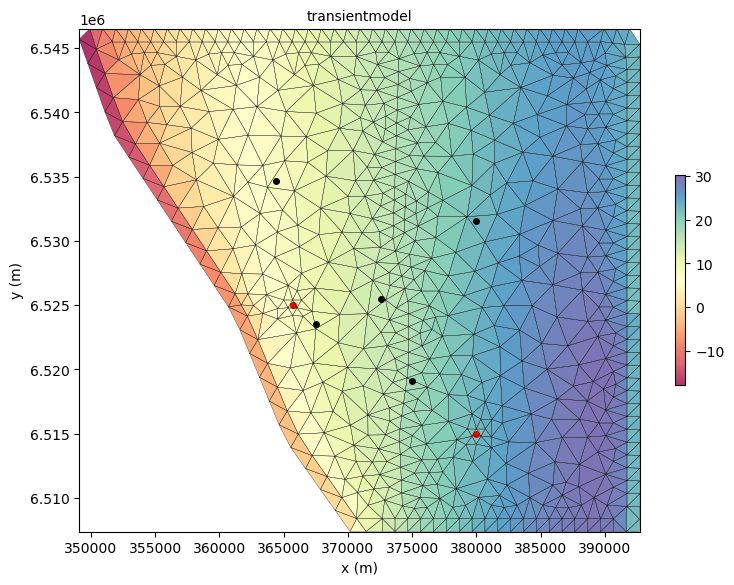

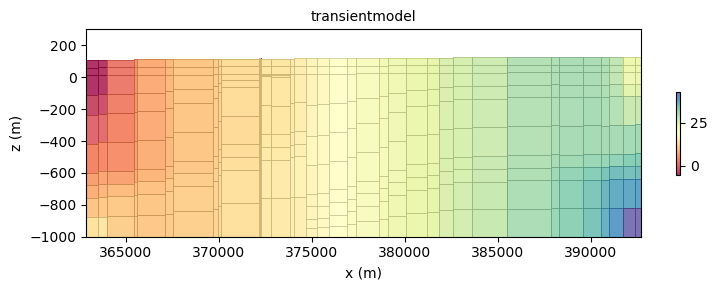

In [65]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)